In [6]:
import numpy as np
import os 
import math 
import librosa 
import scipy 
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt 
from model import read_data, TimeSegment, MyFFT, standardization_row
import h5py
import pickle as pk
import matplotlib.pyplot as plt
import time
import gc

In [5]:
path = '/Users/lei/home/studyhall/smart-earth-sensing/data/*.h5' 
 
# only accepts absolute path 
raw_data, space_interval, sampling_rate = read_data(path, [1920], [1921]) 
with open('pk_files/data_0_1920_1921.pkl', 'wb') as f:
    pk.dump(raw_data, f) 

now file index: 1
now file index: 2
now file index: 3
now file index: 4
now file index: 5
now file index: 6
now file index: 7
now file index: 8
now file index: 9
now file index: 10


In [4]:
path = '/Users/lei/home/studyhall/smart-earth-sensing/data/training_set/*.h5' 
 
# only accepts absolute path 
raw_data, space_interval, sampling_rate = read_data(path, [1920], [1921]) 
with open('pk_files/data_1_1920_1921.pkl', 'wb') as f:
    pk.dump(raw_data, f) 

now file index: 1
now file index: 2
now file index: 3
now file index: 4
now file index: 5
now file index: 6
now file index: 7
now file index: 8
now file index: 9
now file index: 10


In [32]:
data_train = [] 
 
directory = '/Users/lei/home/studyhall/smart-earth-sensing/data/training_set'
for filename in os.listdir(directory):
    if filename.endswith('.h5'):
        raw_data, _, _ = read_data(os.path.join(directory, filename), [1920], [1921]) 
        data_train.append(raw_data) 
 
with open('pk_files/training_set_1920_1921.pkl', 'wb') as f:
    pk.dump(data_train, f) 

now file index: 1
now file index: 1
now file index: 1
now file index: 1
now file index: 1
now file index: 1
now file index: 1
now file index: 1
now file index: 1
now file index: 1


In [10]:
with open('pk_files/data_0_1920_1921.pkl', 'rb') as f:
    raw_data = np.array(pk.load(f))
raw_data.shape 

(1200000, 1)

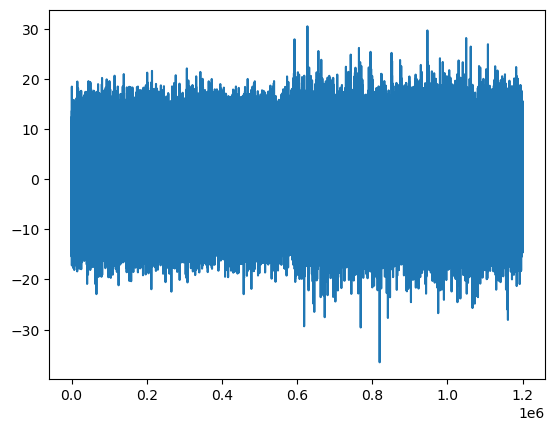

In [4]:
plt.plot(raw_data)
plt.show() 

In [7]:
raw_data = librosa.feature.melspectrogram(y=raw_data, sr=2000)
raw_data 

/Users/lei/anaconda3/envs/smart-earth-sensing/lib/python3.10/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1
  warnings.warn(


array([[[ 1.231565  ],
        [ 1.231565  ],
        [ 1.231565  ],
        ...,
        [ 1.231565  ],
        [ 1.2315649 ],
        [ 1.2315649 ]],

       [[52.93622   ],
        [52.93622   ],
        [52.93622   ],
        ...,
        [52.93622   ],
        [52.936214  ],
        [52.936214  ]],

       [[25.62588   ],
        [25.62588   ],
        [25.62588   ],
        ...,
        [25.62588   ],
        [25.62588   ],
        [25.62588   ]],

       ...,

       [[ 3.6189759 ],
        [ 3.6189759 ],
        [ 3.6189759 ],
        ...,
        [ 3.618976  ],
        [ 3.6189759 ],
        [ 3.618976  ]],

       [[ 0.4341586 ],
        [ 0.43415856],
        [ 0.4341586 ],
        ...,
        [ 0.4341586 ],
        [ 0.4341586 ],
        [ 0.43415862]],

       [[ 0.23082998],
        [ 0.23083001],
        [ 0.23082998],
        ...,
        [ 0.23083003],
        [ 0.23083   ],
        [ 0.23082998]]], dtype=float32)

In [12]:
spec = np.abs(librosa.stft(raw_data, hop_length=512))
spec = librosa.amplitude_to_db(spec, ref=np.max)
librosa.display.specshow(spec, sr=2000, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');
plt.title('Spectrogram');

/Users/lei/anaconda3/envs/smart-earth-sensing/lib/python3.10/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1
  warnings.warn(


In [35]:
with open('pk_files/training_set_1920_1921.pkl', 'rb') as f:
    data_train = np.array(pk.load(f))
data_train.shape

(10, 120000, 1)

In [5]:
sample_size = len(raw_data) 
raw_data_map = {} 
for i in range(0, sample_size): 
    raw_data_map[i] = float(raw_data[i])

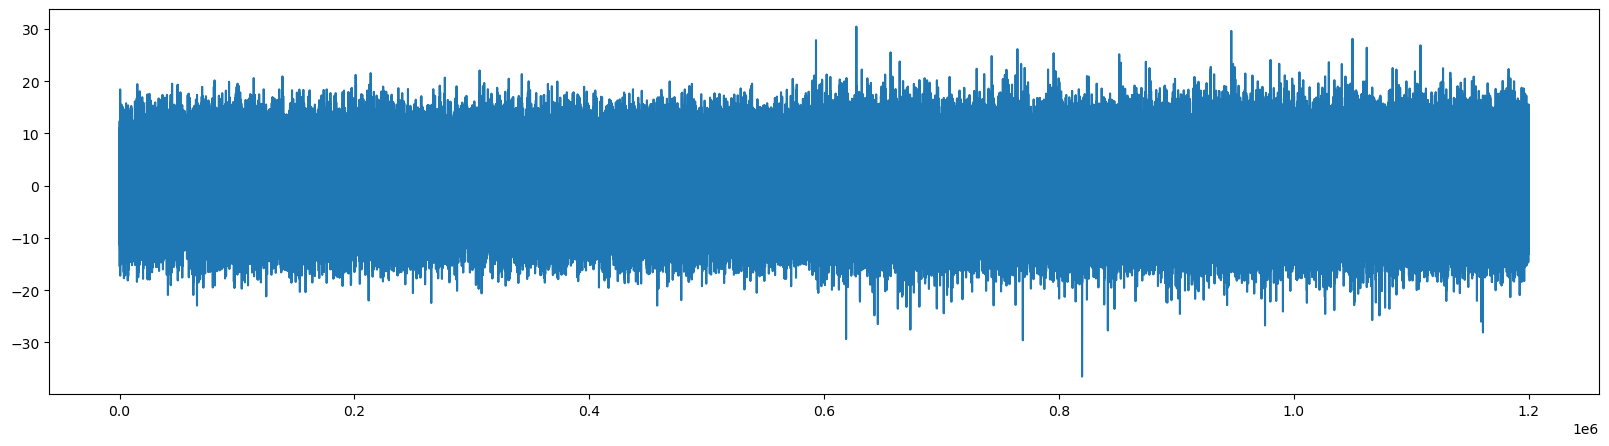

In [6]:
x, y = zip(*raw_data_map.items()) 
plt.figure(figsize=(20, 5)) 
plt.plot(x, y) 
plt.show()

In [7]:
std = np.std(raw_data)
mean = np.mean(raw_data) 
print("standard deviation: " + str(std)) 
print("mean: " + str(mean)) 

standard deviation: 4.9592237
mean: -0.0127028795


In [8]:
suspicious_samples_map = dict(filter(lambda p : (p[1] > mean + 3 * std) or (p[1] < mean - 3 * std), raw_data_map.items()))
print(len(suspicious_samples_map)) 

4724


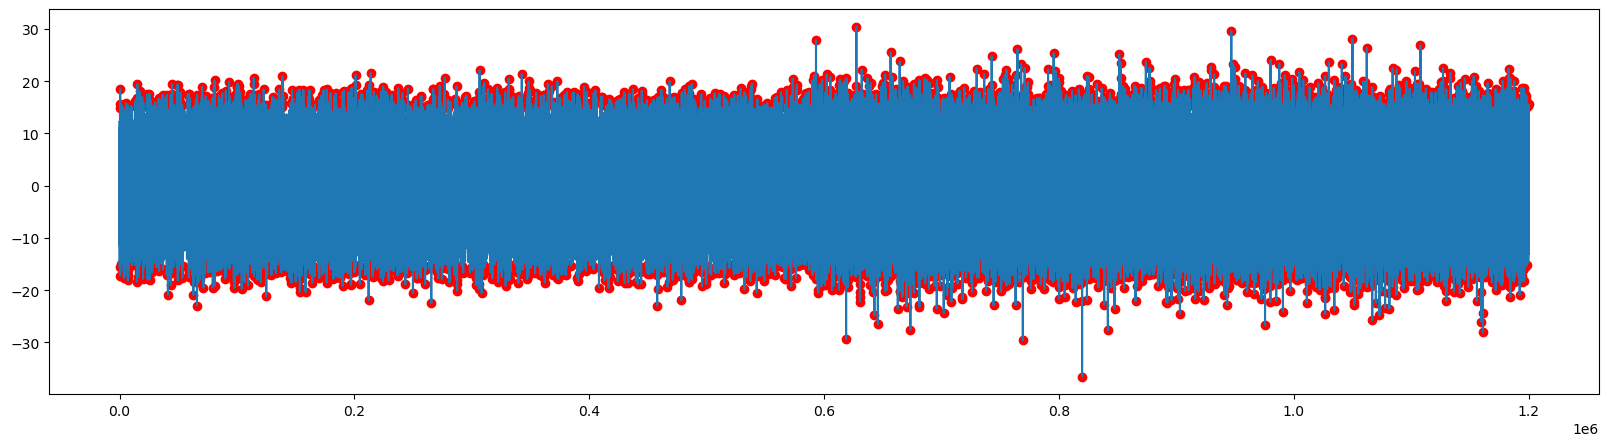

In [9]:
x, y = zip(*raw_data_map.items()) 
suspicious_x, suspicious_y = zip(*suspicious_samples_map.items()) 
plt.figure(figsize=(20, 5)) 
plt.plot(x, y) 
plt.scatter(suspicious_x, suspicious_y, c='red') 
plt.show()

In [10]:
k_means = KMeans(n_clusters=2)
k_means.fit(raw_data) 

/Users/lei/anaconda3/envs/smart-earth-sensing/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=2)

In [14]:
''' 
X: training set. should be an array of samples like z
z: testing sample. the stream data where we want to detect outliers  
t: the length of X 
k: the number of clusters
s: the minimum size of a cluster accepted 
''' 
def clustering_based_outlier_detection(X, Z, k, s):
    # generate all the clusters obtained from the training set X 
    t = len(X) 
    clusters = generate_clusters(X, t, k, s)
    # initialize all preidictions to 0 which represents that the sample is normal 
    preds = np.ones_like(z) 

    # for each sample we have in out testing set z
    # we calculate the distance between the sample and 
    # all the clusters we have
    # if the distance is greater than all existing radius
    # that means the sample is not in any of the clusters we
    # have, making itself a outlier. 
    for i, sample in enumerate(z):
        for center, radius in clusters.items():
            distance = abs(sample - center)
            if distance <= radius:
                preds[i] = 0
    return preds 

''' 
helper function for clustering_based_outlier_detection 
''' 
def generate_clusters(X, t, k, s): 
    # this is map to store clusters we generated
    # an element will be in the form of 'center:radius'
    clusters = {} 
     
    for i in range(0, t):
         
       # define k means clustering obj 
        k_means = KMeans(n_clusters=k) 
         
        # this is the training sample we are dealing with  
        curr_training_sample = X[i] 

        # we perform k means clustering on the training sample and recorde the radius 
        # and center of the clusters accepted
        # notice for a cluster to be accepted, it has to have a size greater than s 
        k_means.fit(curr_training_sample)
         
        centers = k_means.cluster_centers_ 
        preds = k_means.predict(curr_training_sample)
        sample_counts = [] 
        radius = [] 
         
        for i in range(0, len(centers)):
            # get the samples in cluster i 
            samples_clustered = [raw_data[j] for j in range(0, len(raw_data)) if preds[j] == i] 
            # record the number of samples inside cluster i 
            sample_counts.append(len(samples_clustered)) 
            # calculate the radius of cluster i 
            # here the radius is defined as the max
            # distance from the center to a sample inside the cluster 
            radius.append(
                max(
                    list(
                        map(
                            lambda j : abs(centers[i] - samples_clustered[j]),
                            range(0, len(samples_clustered))
                        )
                    )
                )
            )

        # here we filter out the clusters accepted 
        for i in range(0, len(sample_counts)):
            # these clusters are accepted when 
            # its size is greater than s 
            if sample_counts[i] >= s:
                clusters[centers[i]] = radius[i] 
         
    return clusters 

In [24]:
bins = [1, 0, 1, 1, 0, 1 ,1 ,1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
alpha = 0.1 
ref_window_size = 8 
det_window_size = 8 
 
ref_window_start = 0 
ref_window_end = ref_window_start + ref_window_size 
det_window_start = 0
det_window_end = det_window_start + det_window_size 

while det_window_end <= len(bins):
    ref_window = bins[ref_window_start:ref_window_end]
    det_window = bins[det_window_start:det_window_end]
    X = len(list(filter(lambda b : b == 1, ref_window))) 
    Y = len(list(filter(lambda b : b == 1, det_window))) 
    m = ref_window_size
    n = det_window_size
    p1_hat = X / m 
    p2_hat = Y / n 
    p_hat = (X + Y) / (m + n) 

    z0 = (p1_hat - p2_hat) / math.sqrt(p_hat * (1 - p_hat) * (1 / m + 1 / n))
    p_value = scipy.stats.norm.sf(abs(z0)) 
    print(p_value) 
    if p_value >= alpha:
        det_window_start += 1
        det_window_end += 1 
    else:
        print("outlier signaled in interval:") 
        print("start: " + str(det_window_start)) 
        print("end: " + str(det_window_end)) 
        break 
    

0.5
0.29481927581328354
0.29481927581328354
0.1508497912391739
0.0652850090578681
outlier signaled in interval:
start: 4
end: 12


In [27]:
class Window:
    def __init__(self, start, end, size, bins):
        self.start = start
        self.end = end 
        self.size = size 
        self.values = bins[self.start:self.end] 
        self.max = len(bins)
    def shift_left(self):
        if self.end < self.max: 
            self.start += 1
            self.end += 1 
    def shift_right(self):
        if self.start > 0:
            self.start -= 1
            self.end -= 1 
    def over(self):
        return self.end < self.max 

In [28]:
''' 
alpha: varaible used for hypothesis testing 
ref_window: a reference window at current place
det_window: a detection window at current place, notice det_window.end < det_window.max 
''' 
def anomaly_detection_by_hypothesis_testing(alpha, ref_window, det_window):
    ref_window_values = ref_window.values 
    det_window_values = det_window.values
    X = len(list(filter(lambda b : b == 1, ref_window.values))) 
    Y = len(list(filter(lambda b : b == 1, det_window.values))) 
    m = ref_window.size
    n = det_window.size
    p1_hat = X / m 
    p2_hat = Y / n 
    p_hat = (X + Y) / (m + n) 

    z0 = (p1_hat - p2_hat) / math.sqrt(p_hat * (1 - p_hat) * (1 / m + 1 / n))
    p_value = scipy.stats.norm.sf(abs(z0)) 
    return p_value < alpha 
''' 
ref_windows: a list of reference windows with number l and size n 
det_window: a detection window at current place, notice det_window.end < det_window.max
this function does not initialize the windows, it just do the check 
''' 
def anomaly_detection_by_control_charts(ref_windows, det_window):
    l = len(ref_windows) 
    n = ref_windows[0].size 
    D = len(list(filter(lambda b : b == 1, det_window.values))) / len(det_window.size)
    Y_bar = sum(list(map(lambda w : __get_fi(w), ref_windows))) / l
    return math.sin(math.sqrt(D)) ** (-1) > Y_bar + 3 * math.sqrt(1  / (4 * n)) 
         
''' 
helper function for anomaly_detection_by_control charts 
''' 
def __get_fi(window):
    p = len(list(filter(lambda b : b == 1, window.values))) / len(window.size) 
    return (math.sin(math.sqrt(p))) ** (-1)
 

In [ ]:
def anomaly_pattern_detection(X, z, k, s, alpha, n):
    binary_preds = clustering_based_outlier_detection(X, z, k, s)
    ''' 
    now we want to initialize all the windows for both 
    hypothesis testing and control charts 
    ''' 
    # these windows are for hypothesis testing 
    ht_ref_window = Window(start=0, size=n, end=n, bins=binary_preds) 
    ht_det_window = Window(start=0, size=n, end=n, bins=binary_preds) 

     
    # these windows are for control charts 
    # l is the length of the reference window list 
    # here we assume the test sample z has length greater than n + l
    l = 20 
    cc_ref_windows = [Window(start=0, size=n, end=n, bins=binary_preds)]
    cc_det_window = Window(start=0, size=n, end=n, bins=binary_preds) 

    # this is the output list which consists of windows that represent an anomaly section 
    anomalies = [] 

    while ((not ht_det_window.over()) and (not cc_det_window.over())):
        ht_cond = anomaly_detection_by_hypothesis_testing(alpha, ht_ref_window, ht_det_window)
        cc_cond = anomaly_detection_by_control_charts(cc_ref_windows, cc_det_window)
        
        # this means p value >= alpha 
        if not ht_cond:
            # we have to shift the detection window 
            ht_det_window.shift_right() 
        # this means that the formula does not hold 
        if not cc_cond:
            # we have to shift the detection window
            # and create a new reference window which
            # is the latest window created shifted right by 1 
            cc_det_window.shift_right() 
            cc_ref_windows.append(
                Window(
                start=cc_ref_windows[-1].start + 1,
                size=n,
                end=cc_ref_windows[-1].end + 1,
                bins=binary_preds
                )
            ) 

        # if both condition holds, we consider this section 
        # as an anomaly section 
        if ht_cond and cc_cond:
            anomalies.append((ht_det_window, cc_det_window)) 
             
    return anomalies 
             

